In [1]:
#!pip install plotly
#!pip install -U nbformat
#!pip install -U ipywidgets plotly

In [3]:
#!pip install nltk

## Research Question:

1. How do dialogue characteristics differ by user? 
2. How do dialogue characteristics differ by model?
3. How do dialogue characteristics differ by over the course of multi-turn relationships?

In [9]:
# ===== 0. SETUP =====
import os, sys, json, itertools
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="notebook", style="whitegrid")
plt.rcParams["figure.dpi"] = 120

sys.path.append("../")

from src.helpers import io
from src.classes.dataset import Dataset
from src.classes.annotation_set import AnnotationSet

PATH_TO_DATASET = "../data/static/wildchat4k-raw.json"
PATH_TO_ANNOTATIONS_DIR = "../data/static/gpto3mini-json-wildchat"
annotation_key = "automatic_v0-prompt_multi_turn_relationship"

#assert os.path.exists(PATH_TO_DATASET), f"Dataset not found: {PATH_TO_DATASET}"
#assert os.path.isdir(PATH_TO_ANNOTATIONS_DIR), f"Annotations dir not found: {PATH_TO_ANNOTATIONS_DIR}"

# ---- Load dataset (no annotations) ----
dataset = Dataset.load(PATH_TO_DATASET)
print(f"Loaded {len(dataset)} conversations.")

# ---- Load annotations (skip files with unmapped labels) ----
bad_files = []
num_added = 0

for fpath in io.listdir_nohidden(PATH_TO_ANNOTATIONS_DIR):
    try:
        ann = AnnotationSet.load_automatic(path=fpath, source="automatic_v0")
        dataset.add_annotations(ann)
        num_added += 1
    except KeyError as e:
        print(f"[SKIP] {os.path.basename(fpath)} -> unmapped label: {e}")
        bad_files.append((fpath, str(e)))

print(f"Attached annotations from {num_added} files; skipped {len(bad_files)}.")


Loaded 4000 conversations.
prompt-multi_turn_relationship: 0 / 10127 failed due to invalid annotations.
prompt-interaction_features: 0 / 10127 failed due to invalid annotations.
[SKIP] turn_sensitive_use_flags.jsonl -> unmapped label: 'cyberattacks'
turn-topic: 55 / 10127 failed due to invalid annotations.
[SKIP] response_interaction_features.jsonl -> unmapped label: 'content preferences feelings opinions'
[SKIP] prompt_function_purpose.jsonl -> unmapped label: 'role play social simulation platonic companion'
prompt-media_format: 9 / 10127 failed due to invalid annotations.
response-media_format: 0 / 10127 failed due to invalid annotations.
response-answer_form: 0 / 10127 failed due to invalid annotations.
Attached annotations from 6 files; skipped 3.


In [10]:
# ===== 1. HELPERS =====

def unwrap_value(v):
    """If annotation.value is a single-item list, return the item; else return v."""
    if isinstance(v, list) and len(v) == 1:
        return v[0]
    return v

def iter_user_labels(conv, key=annotation_key):
    """Yield normalized user labels for a conversation."""
    for msg in conv.conversation:
        if msg.role == "user" and key in msg.metadata:
            yield unwrap_value(msg.metadata[key].value)

def token_len(text):
    return len((text or "").split())

def role_relative_lengths(dataset):
    """Return dicts: user_turn_lengths[idx]->lengths, assistant_turn_lengths[idx]->lengths."""
    from collections import defaultdict
    user_turn_lengths = defaultdict(list)
    assistant_turn_lengths = defaultdict(list)

    for conv in dataset.data:
        u_idx = a_idx = 0
        for msg in conv.conversation:
            if msg.role == "user":
                user_turn_lengths[u_idx].append(token_len(msg.content))
                u_idx += 1
            elif msg.role == "assistant":
                assistant_turn_lengths[a_idx].append(token_len(msg.content))
                a_idx += 1
    return user_turn_lengths, assistant_turn_lengths

def build_multi_turn_flows(dataset):
    """List of label sequences (user turns only) per conversation."""
    flows = []
    for conv in dataset.data:
        labels = list(iter_user_labels(conv))
        if labels:
            flows.append(labels)
    return flows

def pair_prompt_response(dataset):
    """Align user labels with the *next* assistant response length, per index."""
    rows = []
    for conv in dataset.data:
        model = conv.model
        user_labels = []
        assistant_lengths = []
        for msg in conv.conversation:
            if msg.role == "user" and annotation_key in msg.metadata:
                user_labels.append(unwrap_value(msg.metadata[annotation_key].value))
            elif msg.role == "assistant":
                assistant_lengths.append(token_len(msg.content))
        # align by index
        for i in range(min(len(user_labels), len(assistant_lengths))):
            rows.append({
                "model": model,
                "turn_index": i*2,   # user turns are 0,2,4,...
                "prompt_label": user_labels[i],
                "response_length": assistant_lengths[i]
            })
    return pd.DataFrame(rows)

def top_k_labels(label_counts, k=10):
    """Return top-k label names from a Counter or dict."""
    return [lbl for lbl, _ in Counter(label_counts).most_common(k)]


Conversations with ≥1 labeled user prompt: 3994
Flow length summary: {'count': 3994.0, 'mean': 2.53, 'std': 3.71, 'min': 1.0, '25%': 1.0, '50%': 1.0, '75%': 3.0, 'max': 89.0}
Top labels: [('First Request', 3988), ('New Variation Of Prior Task', 2581), ('Extend, Deepen, Or Build On Prior Task', 1650), ('Completely New Request', 1004), ('Re-Attempt / Revision On Prior Task', 898)]


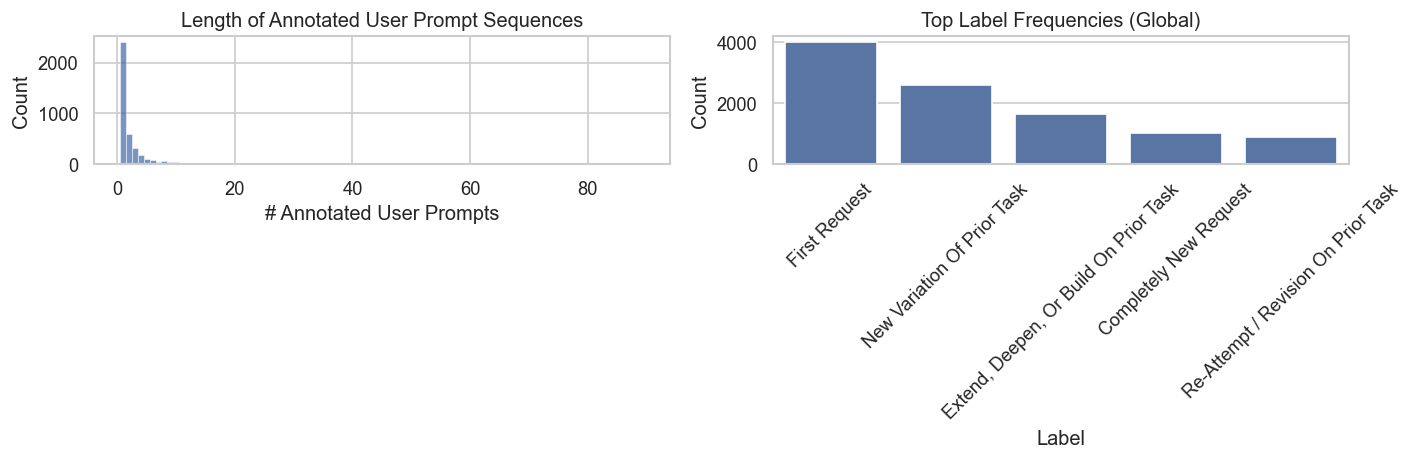

In [11]:
# ===== 2. DESCRIPTIVE FOUNDATIONS =====

# Build derived structures
multi_turn_flows = build_multi_turn_flows(dataset)
print(f"Conversations with ≥1 labeled user prompt: {len(multi_turn_flows)}")

# Flow length distribution (how many labeled user prompts per conversation)
flow_lengths = [len(f) for f in multi_turn_flows]
print("Flow length summary:", pd.Series(flow_lengths).describe().round(2).to_dict())

# Overall label frequency
overall_label_counts = Counter(lbl for flow in multi_turn_flows for lbl in flow)
print("Top labels:", Counter(overall_label_counts).most_common(10))

# Simple plots
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(flow_lengths, bins=range(1, max(flow_lengths)+2), discrete=True, ax=ax[0])
ax[0].set_title("Length of Annotated User Prompt Sequences")
ax[0].set_xlabel("# Annotated User Prompts")

labels_sorted = sorted(overall_label_counts.keys(), key=lambda x: overall_label_counts[x], reverse=True)[:20]
sns.barplot(x=labels_sorted, y=[overall_label_counts[x] for x in labels_sorted], ax=ax[1])
ax[1].set_title("Top Label Frequencies (Global)")
ax[1].set_xlabel("Label"); ax[1].set_ylabel("Count"); ax[1].tick_params(axis='x', rotation=45)
plt.tight_layout(); plt.show()


In [12]:
# ===== 3. RQ1 — BY USER =====

# Per-conversation stats grouped by user
user_conversations = defaultdict(list)

for conv in dataset.data:
    uid = conv.user_id
    labels = list(iter_user_labels(conv))
    if not labels:
        continue
    num_shifts = sum(1 for a, b in zip(labels, labels[1:]) if a != b)
    user_conversations[uid].append({
        "num_turns": len(conv.conversation),
        "num_prompts": len(labels),
        "num_shifts": num_shifts,
        "label_counts": Counter(labels),
    })

# Aggregate per user
rows = []
for uid, convs in user_conversations.items():
    turns = [c["num_turns"] for c in convs]
    prompts = [c["num_prompts"] for c in convs]
    shifts = [c["num_shifts"] for c in convs]
    label_totals = Counter()
    for c in convs:
        label_totals.update(c["label_counts"])
    total_prompts = sum(prompts)
    label_dist_pct = {f"label_{k}": (v/total_prompts) if total_prompts else 0 for k, v in label_totals.items()}
    rows.append({
        "user_id": uid,
        "num_conversations": len(convs),
        "avg_turns_per_conversation": float(np.mean(turns)),
        "avg_annotated_prompts": float(np.mean(prompts)),
        "avg_topic_shifts": float(np.mean(shifts)),
        **label_dist_pct
    })

user_df = pd.DataFrame(rows).sort_values("num_conversations", ascending=False)
print(user_df.head())


                                                user_id  num_conversations  \
627   3e7ae36b9ca739b0e16876727814a0e8470c8496aab833...                 43   
1937  2eef7d0f0b5b3cdd22f40849eefe0f13b05730cffa5bfd...                 34   
331   2a28eab6a25a22abbe8a2de22f61e06101936bad97e1b8...                 29   
1471  25fe0280393351ba0fcf578cad274f8f2ca29975caa299...                 27   
532   a89177c80571053584234edca85f348690bf0ab5873876...                 22   

      avg_turns_per_conversation  avg_annotated_prompts  avg_topic_shifts  \
627                     2.604651               1.302326          0.186047   
1937                    2.588235               1.294118          0.264706   
331                     9.448276               4.724138          1.931034   
1471                    2.000000               1.000000          0.000000   
532                     6.000000               3.000000          1.227273   

      label_First Request  label_New Variation Of Prior Task  \
627 

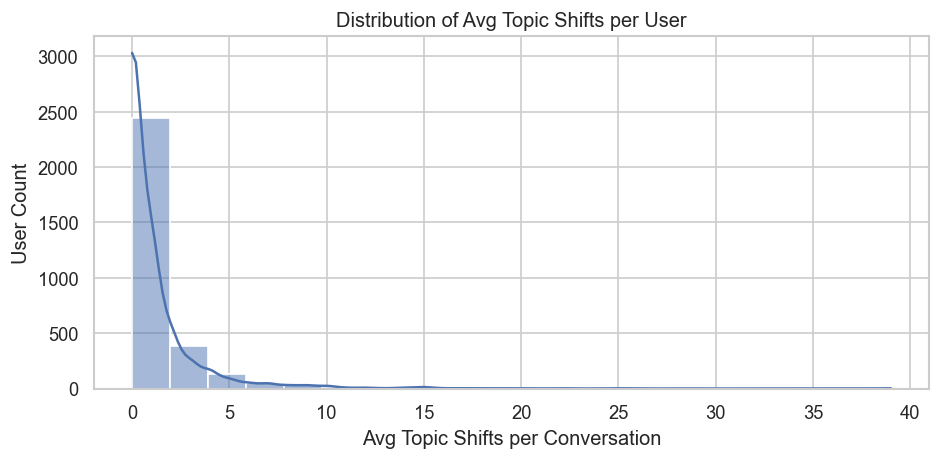

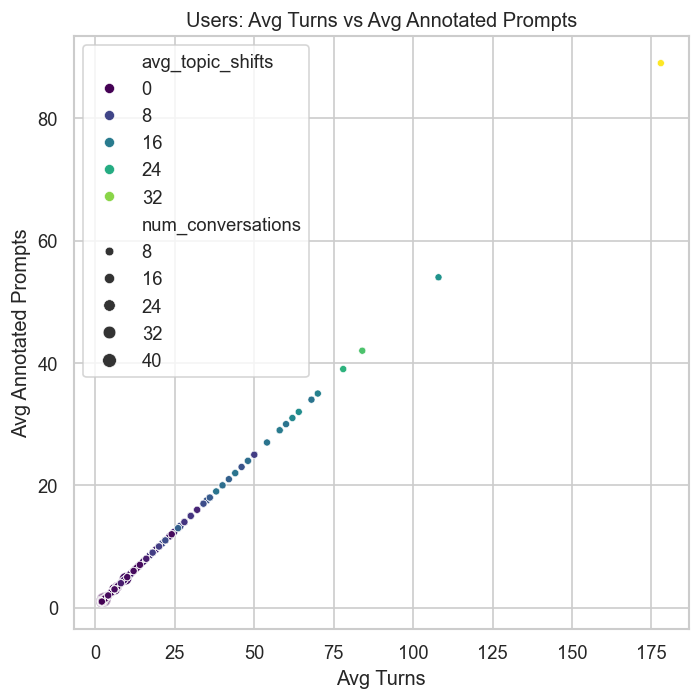

In [13]:
# Hist: average topic shifts per user
plt.figure(figsize=(8,4))
sns.histplot(user_df["avg_topic_shifts"], bins=20, kde=True)
plt.title("Distribution of Avg Topic Shifts per User")
plt.xlabel("Avg Topic Shifts per Conversation"); plt.ylabel("User Count")
plt.tight_layout(); plt.show()

# Scatter: avg turns vs avg annotated prompts (size = num_conversations)
plt.figure(figsize=(6,6))
sns.scatterplot(
    data=user_df, x="avg_turns_per_conversation", y="avg_annotated_prompts",
    size="num_conversations", hue="avg_topic_shifts", palette="viridis", legend="brief"
)
plt.title("Users: Avg Turns vs Avg Annotated Prompts"); plt.xlabel("Avg Turns"); plt.ylabel("Avg Annotated Prompts")
plt.tight_layout(); plt.show()


In [14]:
# ===== 4. RQ2 — BY MODEL =====
model_stats = defaultdict(list)

for conv in dataset.data:
    model = conv.model
    labels = []
    assistant_lengths = []
    for msg in conv.conversation:
        if msg.role == "user" and annotation_key in msg.metadata:
            labels.append(unwrap_value(msg.metadata[annotation_key].value))
        elif msg.role == "assistant":
            assistant_lengths.append(token_len(msg.content))
    if not labels:
        continue
    num_shifts = sum(1 for a, b in zip(labels, labels[1:]) if a != b)
    label_counts = Counter(labels)
    model_stats[model].append({
        "num_turns": len(conv.conversation),
        "avg_assistant_len": float(np.mean(assistant_lengths)) if assistant_lengths else 0.0,
        "num_prompts": len(labels),
        "num_shifts": num_shifts,
        "label_counts": label_counts
    })

rows = []
for model, convs in model_stats.items():
    turns = [c["num_turns"] for c in convs]
    lengths = [c["avg_assistant_len"] for c in convs]
    prompts = [c["num_prompts"] for c in convs]
    shifts = [c["num_shifts"] for c in convs]
    label_totals = Counter()
    for c in convs: label_totals.update(c["label_counts"])
    total_prompts = sum(prompts)
    label_dist_pct = {f"label_{k}": (v/total_prompts) if total_prompts else 0 for k, v in label_totals.items()}
    rows.append({
        "model": model,
        "num_conversations": len(convs),
        "avg_turns": float(np.mean(turns)),
        "avg_assistant_length": float(np.mean(lengths)),
        "avg_annotated_prompts": float(np.mean(prompts)),
        "avg_topic_shifts": float(np.mean(shifts)),
        **label_dist_pct
    })

model_df = pd.DataFrame(rows).sort_values("num_conversations", ascending=False)
print(model_df.head())


                model  num_conversations  avg_turns  avg_assistant_length  \
2  gpt-3.5-turbo-0613               1862   4.111708            233.119710   
0  gpt-3.5-turbo-0301                703   6.716927            137.643938   
3  gpt-4-1106-preview                631   6.494453            287.703566   
5  gpt-4-0125-preview                310   6.664516            320.773520   
4  gpt-3.5-turbo-0125                298   3.422819            214.490155   

   avg_annotated_prompts  avg_topic_shifts  label_First Request  \
2               2.055854          0.699785             0.486155   
0               3.358464          1.486486             0.298602   
3               3.247227          1.364501             0.306491   
5               3.332258          1.341935             0.299129   
4               1.711409          0.533557             0.580392   

   label_New Variation Of Prior Task  label_Completely New Request  \
2                           0.236416                      0.0773

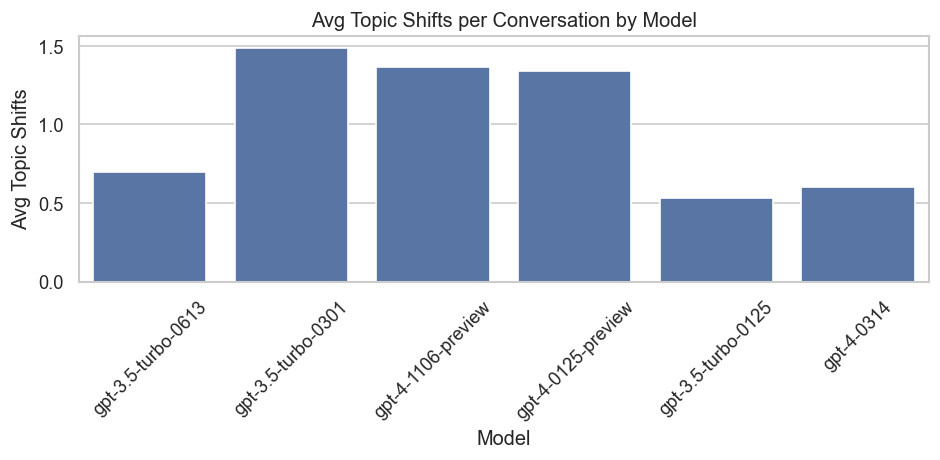

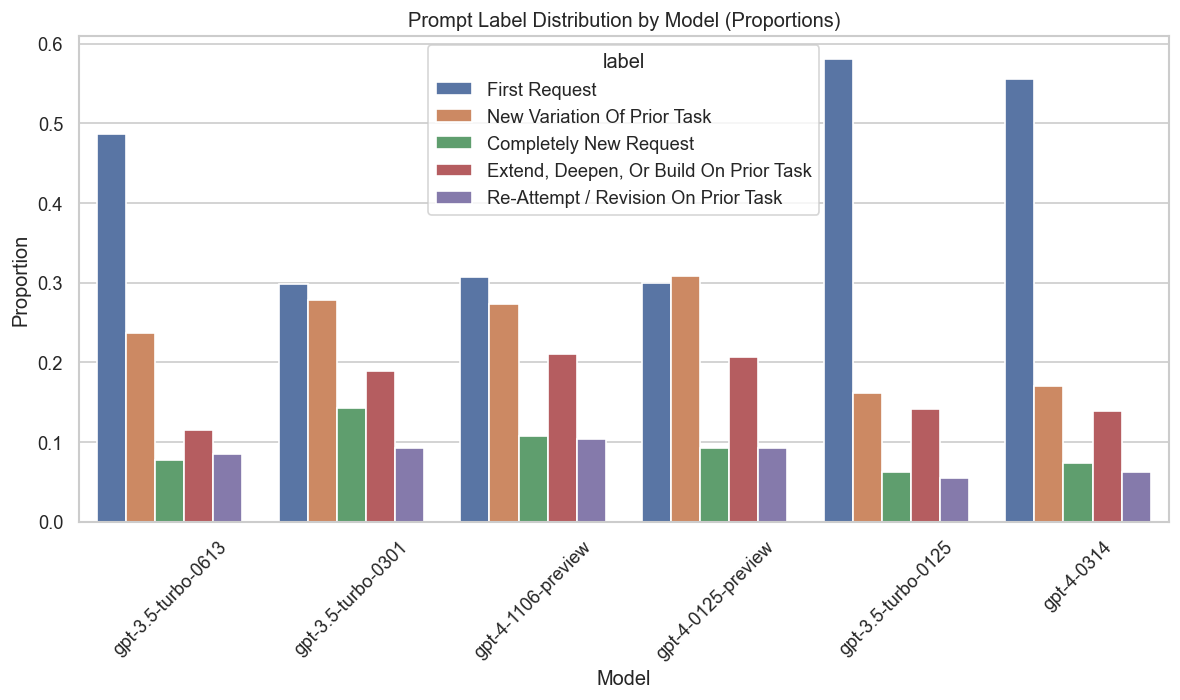

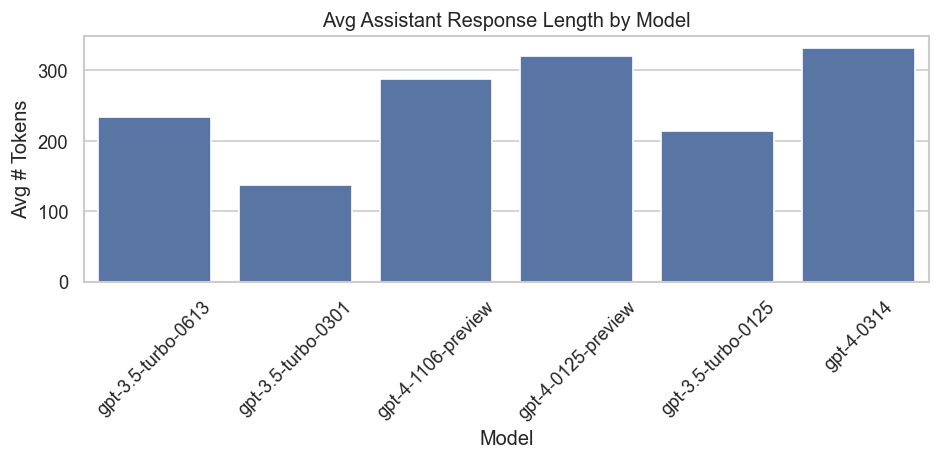

In [15]:
# Avg topic shifts by model
plt.figure(figsize=(8,4))
sns.barplot(data=model_df, x="model", y="avg_topic_shifts")
plt.title("Avg Topic Shifts per Conversation by Model")
plt.ylabel("Avg Topic Shifts"); plt.xlabel("Model"); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

# Label distribution by model (stacked option: cluster by hue)
label_cols = [c for c in model_df.columns if c.startswith("label_")]
melted = model_df[["model"] + label_cols].melt(id_vars="model", var_name="label", value_name="proportion")
melted["label"] = melted["label"].str.replace("^label_", "", regex=True)

plt.figure(figsize=(10,6))
sns.barplot(data=melted, x="model", y="proportion", hue="label")
plt.title("Prompt Label Distribution by Model (Proportions)")
plt.ylabel("Proportion"); plt.xlabel("Model"); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

# Avg assistant response length by model
plt.figure(figsize=(8,4))
sns.barplot(data=model_df, x="model", y="avg_assistant_length")
plt.title("Avg Assistant Response Length by Model")
plt.ylabel("Avg # Tokens"); plt.xlabel("Model"); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()


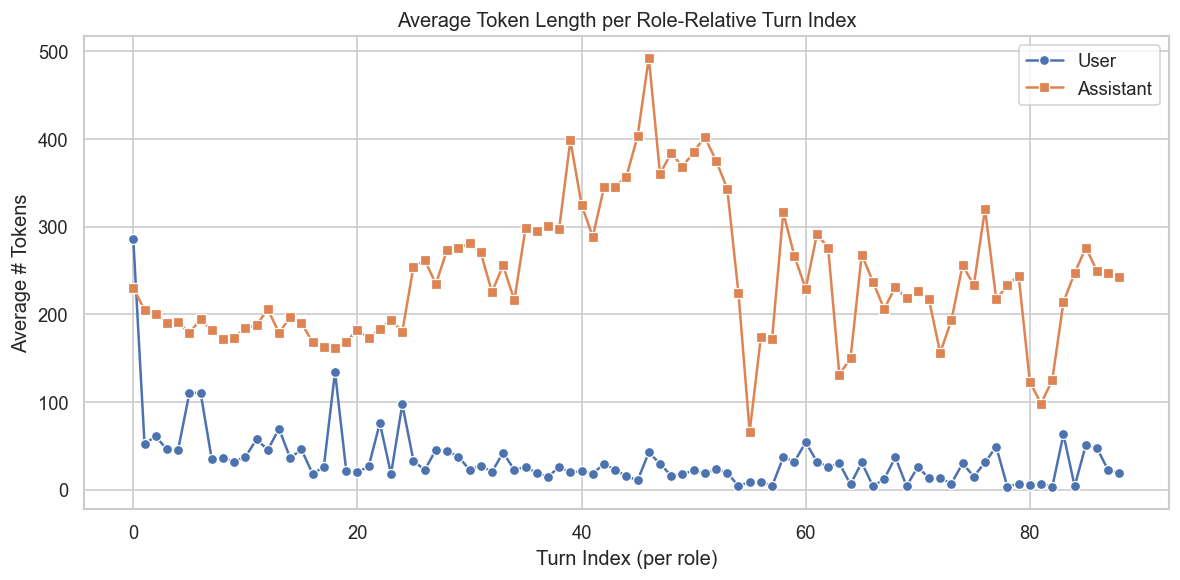

In [16]:
# ===== 5. RQ3 — OVER MULTI-TURN =====

# Role-relative lengths
user_turn_lengths, assistant_turn_lengths = role_relative_lengths(dataset)

avg_user_len_by_index = {i: float(np.mean(v)) for i, v in user_turn_lengths.items()}
avg_assistant_len_by_index = {i: float(np.mean(v)) for i, v in assistant_turn_lengths.items()}

plt.figure(figsize=(10,5))
sns.lineplot(x=list(avg_user_len_by_index.keys()), y=list(avg_user_len_by_index.values()),
             marker="o", label="User")
sns.lineplot(x=list(avg_assistant_len_by_index.keys()), y=list(avg_assistant_len_by_index.values()),
             marker="s", label="Assistant")
plt.title("Average Token Length per Role-Relative Turn Index")
plt.xlabel("Turn Index (per role)"); plt.ylabel("Average # Tokens"); plt.legend()
plt.tight_layout(); plt.show()


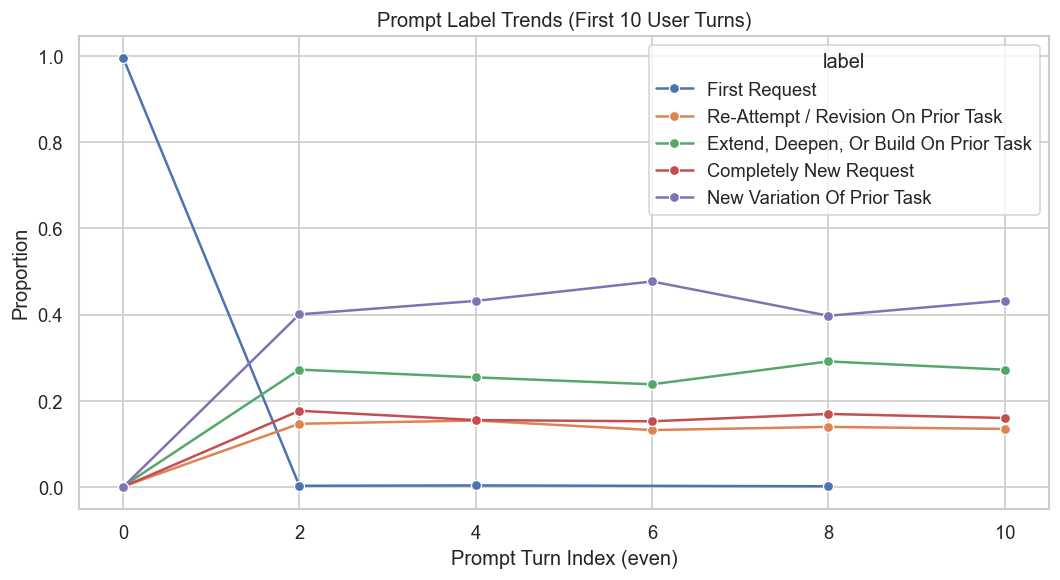

In [24]:
# Build per-turn (user) label table with proportions
turn_counts = defaultdict(Counter)
for flow in multi_turn_flows:
    for i, lbl in enumerate(flow):
        turn_counts[i][lbl] += 1

rows = []
for i, cnt in turn_counts.items():
    total = sum(cnt.values())
    for lbl, c in cnt.items():
        rows.append({"turn_index": i*2, "label": lbl, "proportion": c/total if total else 0.0})

turn_df = pd.DataFrame(rows)

# Plot first N user turns (even indices)
turn_cutoff = 12
filtered_df = turn_df[turn_df["turn_index"] < turn_cutoff]

plt.figure(figsize=(9,5))
sns.lineplot(data=filtered_df, x="turn_index", y="proportion", hue="label", marker="o")
plt.title("Prompt Label Trends (First 10 User Turns)")
plt.xlabel("Prompt Turn Index (even)"); plt.ylabel("Proportion"); plt.xticks(range(0, turn_cutoff, 2))
plt.tight_layout(); plt.show()


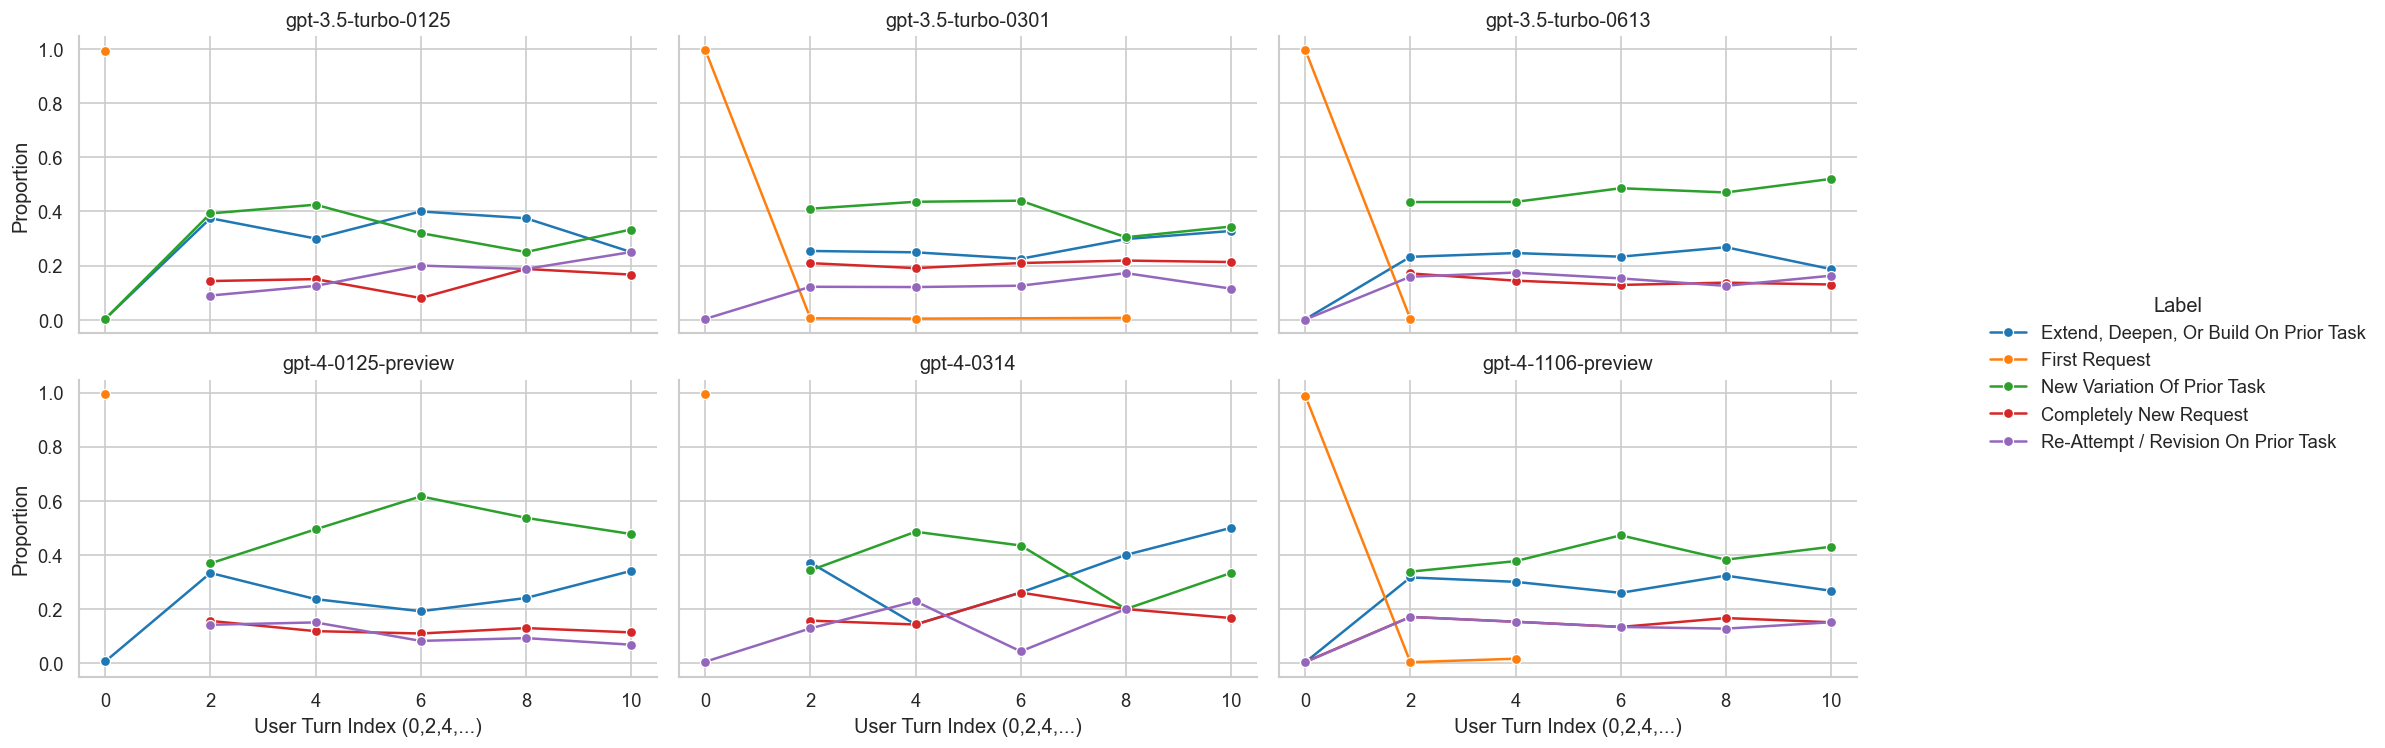

In [33]:
# --- By-model version of prompt label trends ---

annotation_key = "automatic_v0-prompt_multi_turn_relationship"

def unwrap(v):
    return v[0] if isinstance(v, list) and len(v) == 1 else v

# Build (model, user_turn_index, label) table
records = []
for conv in dataset.data:
    model = conv.model
    u_idx = 0
    for msg in conv.conversation:
        if msg.role == "user" and annotation_key in msg.metadata:
            lbl = unwrap(msg.metadata[annotation_key].value)
            raw_idx = u_idx * 2  # map to raw turn index (0,2,4,...)
            records.append({"model": model, "turn_index": raw_idx, "label": lbl})
            u_idx += 1

turn_df_model = pd.DataFrame(records)
if turn_df_model.empty:
    raise ValueError("No labeled user prompts found.")

# Collapse to top-K labels to avoid clutter
K = 6
global_counts = Counter(turn_df_model["label"])
top_labels = {lbl for lbl, _ in global_counts.most_common(K)}
turn_df_model["label"] = np.where(
    turn_df_model["label"].isin(top_labels), turn_df_model["label"], "Other"
)

# Compute per-(model, turn, label) proportions
grp = (
    turn_df_model
    .groupby(["model", "turn_index", "label"])
    .size()
    .rename("count")
    .reset_index()
)
grp["total"] = grp.groupby(["model", "turn_index"])["count"].transform("sum")
grp["proportion"] = grp["count"] / grp["total"]

# ---- Plot: Faceted line plot by model with consistent legend ----
TURN_CUTOFF = 12
plotA = grp[grp["turn_index"] < TURN_CUTOFF].copy()

labels_sorted = sorted(plotA["label"].unique())
palette = sns.color_palette("tab10", n_colors=len(labels_sorted))

g = sns.FacetGrid(
    data=plotA,
    col="model", col_wrap=3, height=3.2, aspect=1.3,
    sharey=True, sharex=True,
    hue="label", palette=palette
)
g.map_dataframe(sns.lineplot, x="turn_index", y="proportion", marker="o")

# One consolidated legend outside the grid
g.add_legend(title="Label", bbox_to_anchor=(1.05, 0.5), loc="center left")
g.set_axis_labels("User Turn Index (0,2,4,...)", "Proportion")
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    ax.set_xticks(range(0, TURN_CUTOFF, 2))
plt.tight_layout()
plt.show()


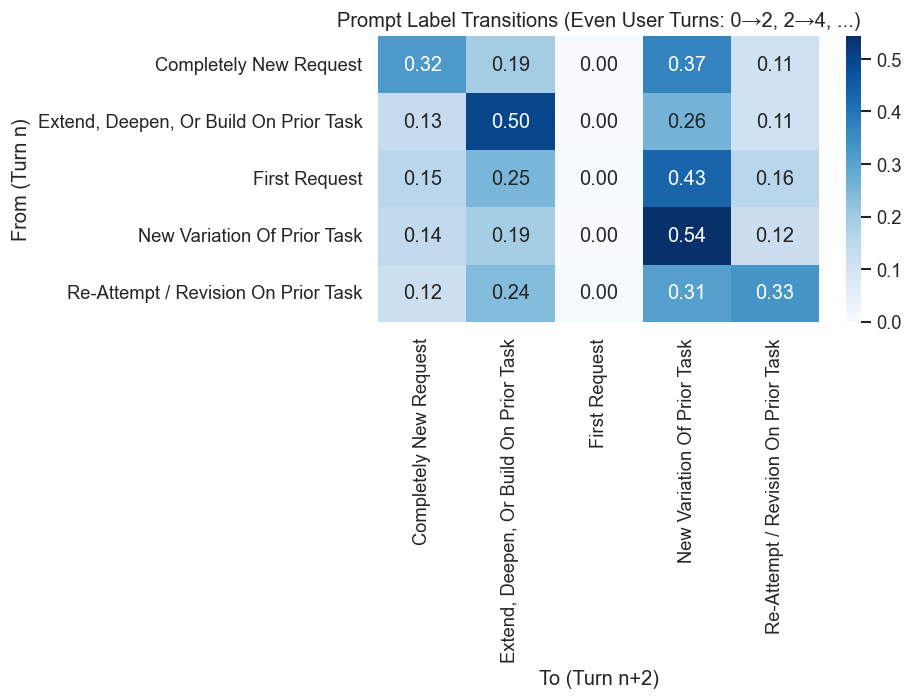

In [18]:
# Aggregate even-turn transitions across all flows
even_transitions = Counter()
for flow in multi_turn_flows:
    # 0->1 in 'flow' corresponds to 0->2 in raw turns; we step by 1 within user-only series
    for i in range(0, len(flow) - 2, 2):  # if you want skip-every-other within user-only, keep step=2
        src, tgt = flow[i], flow[i+2]
        even_transitions[(src, tgt)] += 1

# Build matrix
all_labels = sorted(set([s for s, _ in even_transitions] + [t for _, t in even_transitions]))
mat = pd.DataFrame(0, index=all_labels, columns=all_labels)
for (s, t), c in even_transitions.items():
    mat.loc[s, t] = c

# Row-normalize
mat_prob = mat.div(mat.sum(axis=1), axis=0).fillna(0)

plt.figure(figsize=(8,6))
sns.heatmap(mat_prob, annot=True, fmt=".2f", cmap="Blues")
plt.title("Prompt Label Transitions (Even User Turns: 0→2, 2→4, ...)")
plt.xlabel("To (Turn n+2)"); plt.ylabel("From (Turn n)")
plt.tight_layout(); plt.show()


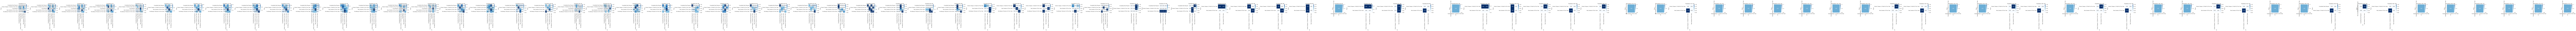

In [19]:
# Build per-pair transitions: (0->2), (2->4), ...
pair_transitions = defaultdict(Counter)
for flow in multi_turn_flows:
    for i in range(len(flow) - 1):
        src, tgt = flow[i], flow[i+1]  # user-only consecutive labels => even to next even in raw conversation
        pair_transitions[f"{i*2}->{(i+1)*2}"][(src, tgt)] += 1

# Plot small multiples
pairs_sorted = sorted(pair_transitions.keys(), key=lambda x: int(x.split("->")[0]))
n = len(pairs_sorted)
if n == 0:
    print("No turn-pair transitions to plot.")
else:
    fig, axes = plt.subplots(1, n, figsize=(5*n, 5), squeeze=False)
    for ax, key in zip(axes[0], pairs_sorted):
        trans = pair_transitions[key]
        labels = sorted(set(itertools.chain.from_iterable(trans.keys())))
        df = pd.DataFrame(0, index=labels, columns=labels)
        for (s, t), c in trans.items():
            df.loc[s, t] = c
        # optional row-normalize
        df = df.div(df.sum(axis=1), axis=0).fillna(0)
        sns.heatmap(df, annot=True, fmt=".2f", cmap="Blues", ax=ax)
        ax.set_title(f"Transitions {key}")
        ax.set_xlabel("To"); ax.set_ylabel("From")
    plt.tight_layout(); plt.show()


                model  turn_index                 prompt_label  \
0  gpt-3.5-turbo-0301           0                First Request   
1  gpt-3.5-turbo-0301           2  New Variation Of Prior Task   
2  gpt-3.5-turbo-0301           4       Completely New Request   
3  gpt-3.5-turbo-0301           6       Completely New Request   
4  gpt-3.5-turbo-0301           8       Completely New Request   

   response_length  
0                1  
1                3  
2               12  
3                8  
4               10  


/var/folders/rr/y8s07jcj3fz4_jzgdftt8qyh0000gq/T/ipykernel_90448/2429833468.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=pairwise_df, x="prompt_label", y="response_length", ci="sd")


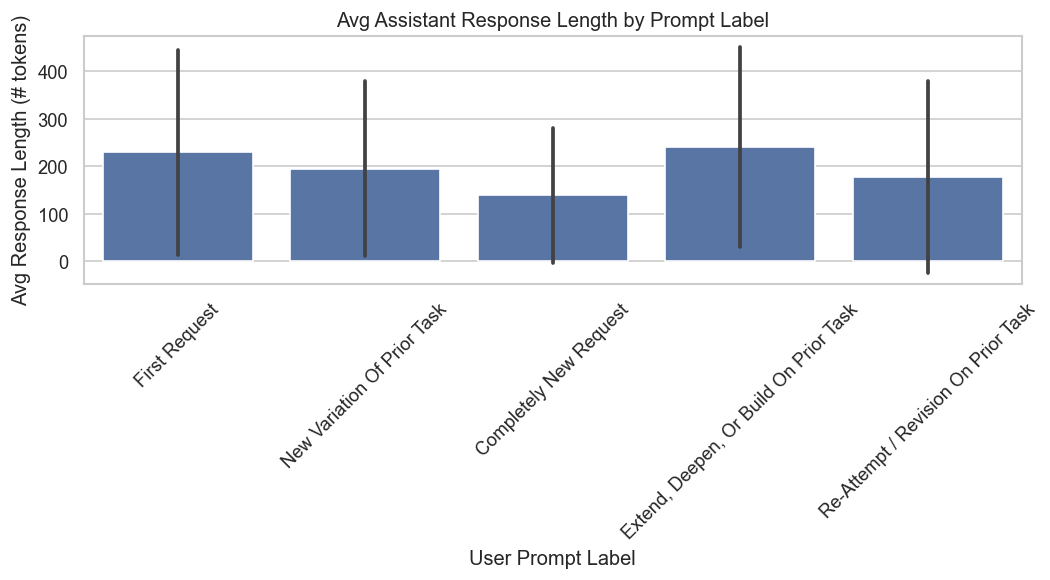

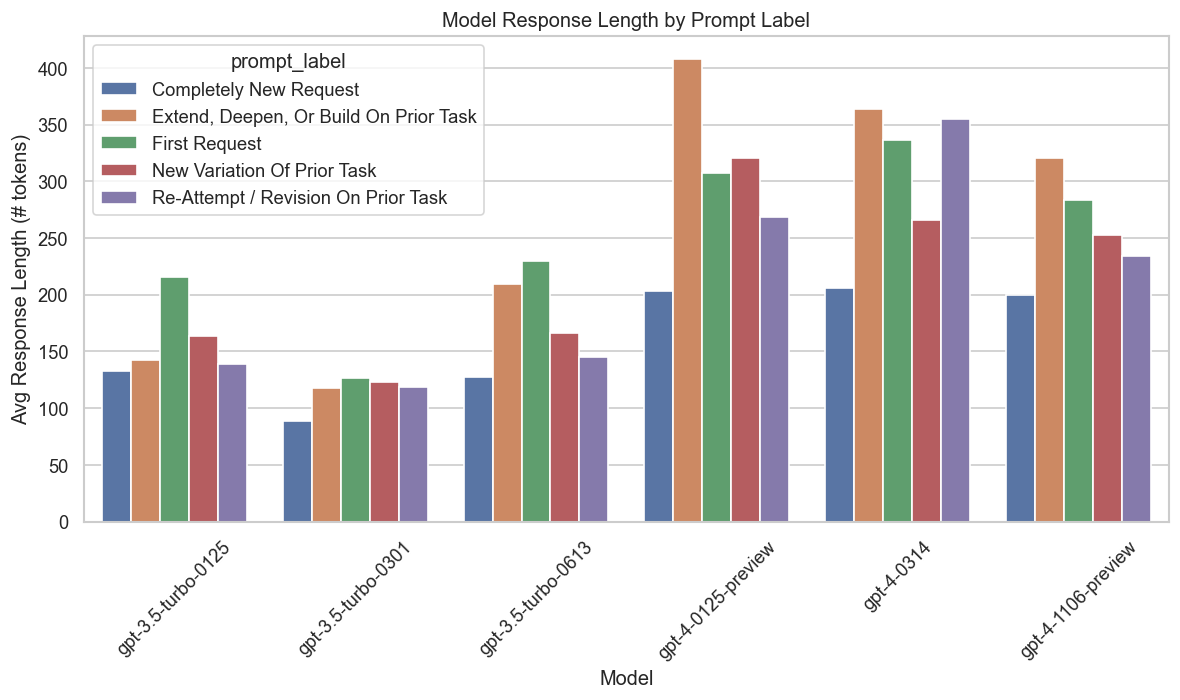

In [20]:
# Pairwise prompt-response alignment table
pairwise_df = pair_prompt_response(dataset)
print(pairwise_df.head())

# Avg response length by prompt label
plt.figure(figsize=(9,5))
sns.barplot(data=pairwise_df, x="prompt_label", y="response_length", ci="sd")
plt.title("Avg Assistant Response Length by Prompt Label")
plt.xlabel("User Prompt Label"); plt.ylabel("Avg Response Length (# tokens)")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# By model & label
grp = pairwise_df.groupby(["model", "prompt_label"])["response_length"].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=grp, x="model", y="response_length", hue="prompt_label")
plt.title("Model Response Length by Prompt Label")
plt.ylabel("Avg Response Length (# tokens)"); plt.xlabel("Model")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()


/var/folders/rr/y8s07jcj3fz4_jzgdftt8qyh0000gq/T/ipykernel_90448/1538470829.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=pairwise_top, x="prompt_label", y="response_length", ci="sd")


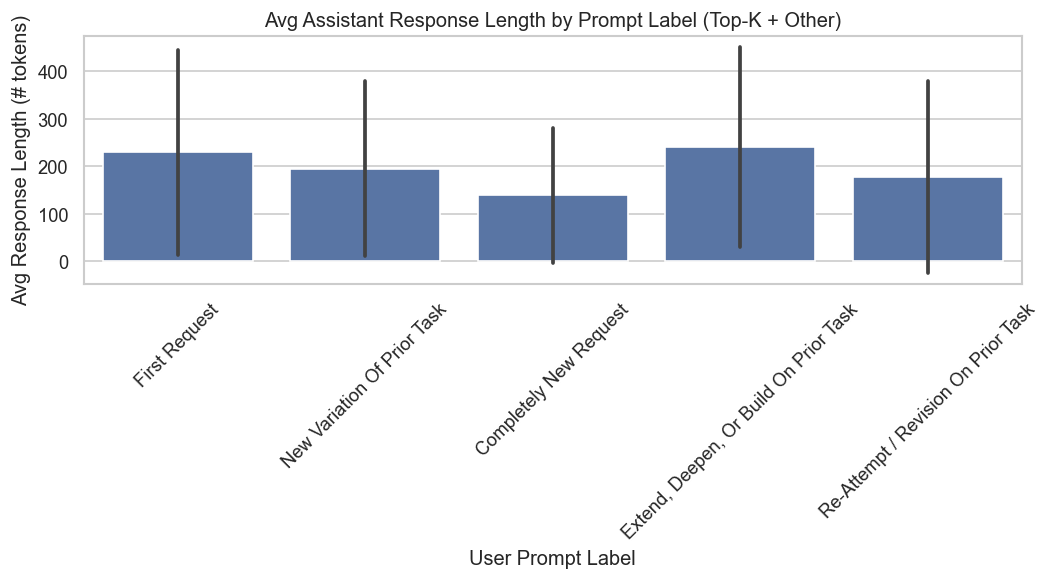

In [21]:
# Example: focus on top-K labels to reduce clutter
K = 6
top_labels = top_k_labels(overall_label_counts, k=K)

pairwise_top = pairwise_df.copy()
pairwise_top["prompt_label"] = pairwise_top["prompt_label"].where(pairwise_top["prompt_label"].isin(top_labels), "Other")

plt.figure(figsize=(9,5))
sns.barplot(data=pairwise_top, x="prompt_label", y="response_length", ci="sd")
plt.title("Avg Assistant Response Length by Prompt Label (Top-K + Other)")
plt.xlabel("User Prompt Label"); plt.ylabel("Avg Response Length (# tokens)")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()


In [39]:
# === Sankey diagrams for user prompt label flows (overall + per-model) ===

# Uses Plotly (pip install plotly if needed).

import os
from collections import Counter
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# ---------------- CONFIG ----------------
ANNOTATION_KEY   = "automatic_v0-prompt_multi_turn_relationship"
MAX_USER_TURNS   = 4      # number of user turns to display: U0→U1→... up to this many
TOP_K_LABELS     = 10      # keep top-K labels; collapse rest to "Other"
SAVE_HTML        = False  # set True to save figures as HTML instead of (or in addition to) .show()
OUTPUT_DIR       = "./sankey_outputs"
MIN_CONV_PER_MODEL = 3    # warn if a model has fewer than this many conversations
# ---------------------------------------

def unwrap(v):
    return v[0] if isinstance(v, list) and len(v) == 1 else v

def build_conv_flows(dataset, annotation_key=ANNOTATION_KEY):
    """
    Returns: list of dicts, each: {"model": str, "labels": [lbl0, lbl1, ...]}
    Only includes conversations with >= 1 labeled user prompt.
    """
    conv_flows = []
    for conv in dataset.data:
        labels = []
        for msg in conv.conversation:
            if msg.role == "user" and annotation_key in msg.metadata:
                labels.append(unwrap(msg.metadata[annotation_key].value))
        if labels:
            conv_flows.append({"model": conv.model, "labels": labels})
    return conv_flows

def collapse_labels_in_place(conv_flows, top_k=TOP_K_LABELS):
    """
    Collapses infrequent labels into 'Other' based on global frequency across all flows.
    """
    if top_k is None:
        return
    global_counts = Counter(lbl for rec in conv_flows for lbl in rec["labels"])
    top = {lbl for lbl, _ in global_counts.most_common(top_k)}
    for rec in conv_flows:
        rec["labels"] = [lbl if lbl in top else "Other" for lbl in rec["labels"]]

def build_sankey_arrays(flows, max_user_turns=MAX_USER_TURNS, raw_index_labels=False):
    """
    Build node/link arrays for Plotly Sankey from a list of flows:
    flows: [{"labels": [..]}, ...]
    - max_user_turns: consider first N user turns (U0..U{N-1})
    - raw_index_labels: if True, show node labels as raw indices (0,2,4,...) instead of role-relative U0,U1,...
    Returns: node_labels, src_idx, tgt_idx, values
    """
    stage_labels = [set() for _ in range(max_user_turns)]
    links_counter = Counter()  

    for rec in flows:
        seq = rec["labels"][:max_user_turns]
        if len(seq) < 2:
            continue
        for i in range(len(seq)):
            stage_labels[i].add(seq[i])
        for i in range(len(seq) - 1):
            links_counter[(i, seq[i], seq[i+1])] += 1

    # Build node list (stage-aware indices)
    node_labels = []
    node_index = {}
    for s in range(max_user_turns):
        ordered = sorted(stage_labels[s])
        for lbl in ordered:
            node_index[(s, lbl)] = len(node_labels)
            turn_tag = (2*s) if raw_index_labels else s  # raw: 0,2,4,... or role-relative: 0,1,2,...
            node_labels.append(f"{lbl} (t{turn_tag})")

    # Build links
    src_idx, tgt_idx, values = [], [], []
    for (s, src_lbl, tgt_lbl), cnt in links_counter.items():
        if (s, src_lbl) in node_index and (s+1, tgt_lbl) in node_index:
            src_idx.append(node_index[(s, src_lbl)])
            tgt_idx.append(node_index[(s+1, tgt_lbl)])
            values.append(cnt)

    return node_labels, src_idx, tgt_idx, values

def plot_sankey(flows, title, max_user_turns=MAX_USER_TURNS, raw_index_labels=False,
                save_html=SAVE_HTML, out_path=None, width=980, height=560):
    """
    Render a Sankey diagram for the given flows.
    If save_html=True and out_path is provided, saves to HTML.
    """
    node_labels, src, tgt, val = build_sankey_arrays(
        flows, max_user_turns=max_user_turns, raw_index_labels=raw_index_labels
    )

    fig = go.Figure(data=[go.Sankey(
        arrangement="snap",
        node=dict(
            pad=18, thickness=18, line=dict(color="black", width=0.5),
            label=node_labels
        ),
        link=dict(source=src, target=tgt, value=val)
    )])
    fig.update_layout(title=title, font_size=12, width=width, height=height)

    if save_html and out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        fig.write_html(out_path)
    else:
        fig.show()

# ---------- Run pipeline ----------
conv_flows = build_conv_flows(dataset, ANNOTATION_KEY)
collapse_labels_in_place(conv_flows, TOP_K_LABELS)

# Overall Sankey (all models pooled)
plot_sankey(
    conv_flows,
    title=f"Overall User Prompt Label Flows (Top-{TOP_K_LABELS} labels; first {MAX_USER_TURNS} user turns)",
    max_user_turns=MAX_USER_TURNS,
    raw_index_labels=False,   # set True if you want node labels to show raw indices 0,2,4,...
    save_html=SAVE_HTML,
    out_path=os.path.join(OUTPUT_DIR, "sankey_overall.html") if SAVE_HTML else None
)

# Per-model Sankeys
models = sorted({rec["model"] for rec in conv_flows})
for m in models:
    flows_m = [rec for rec in conv_flows if rec["model"] == m]
    if len(flows_m) < MIN_CONV_PER_MODEL:
        print(f"[warn] Model '{m}' has only {len(flows_m)} conversations; diagram may be noisy.")
    safe_m = "".join(ch if ch.isalnum() or ch in "-._" else "_" for ch in m)
    plot_sankey(
        flows_m,
        title=f"User Prompt Label Flows — {m} (Top-{TOP_K_LABELS}; first {MAX_USER_TURNS} user turns)",
        max_user_turns=MAX_USER_TURNS,
        raw_index_labels=False,
        save_html=SAVE_HTML,
        out_path=os.path.join(OUTPUT_DIR, f"sankey_{safe_m}.html") if SAVE_HTML else None
    )


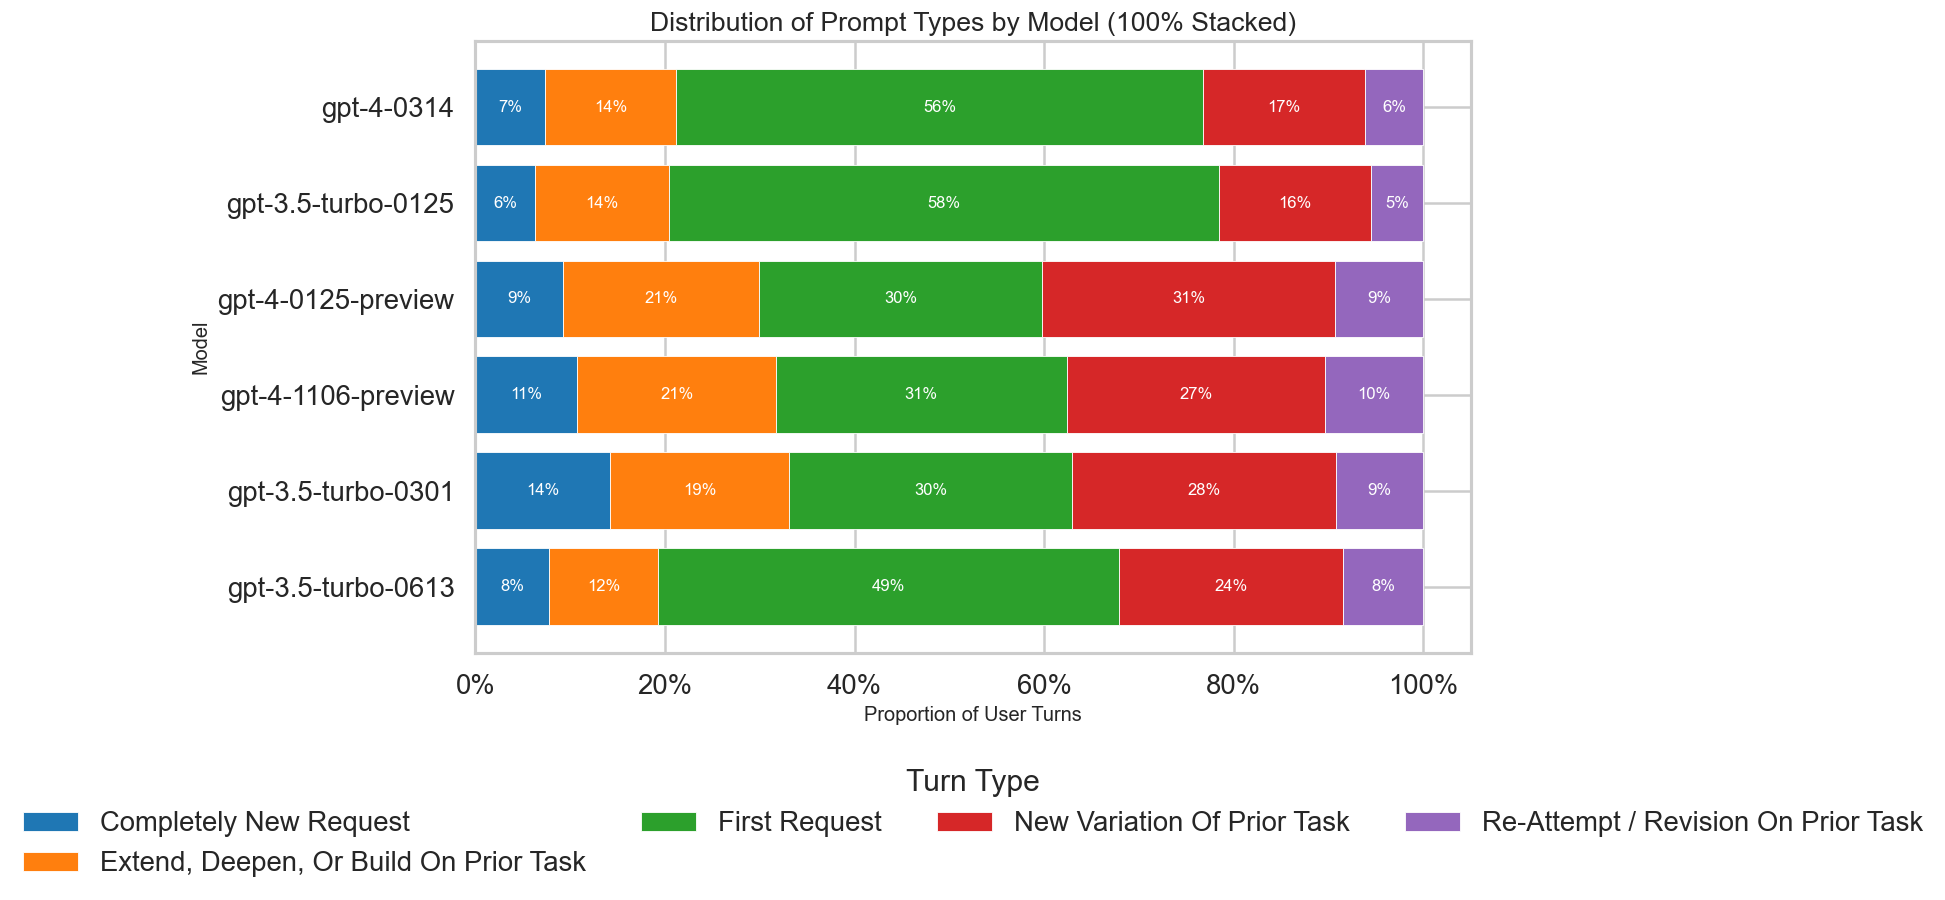

In [43]:
from matplotlib.ticker import PercentFormatter

pivot_df = dist.pivot(index="model", columns="label", values="proportion").fillna(0)

# Order models by sample size (descending)
model_counts = turn_df_model.groupby("model").size().sort_values(ascending=False)
pivot_df = pivot_df.loc[model_counts.index.intersection(pivot_df.index)]

labels_order = sorted(pivot_df.columns)
colors = sns.color_palette("tab10", n_colors=len(labels_order))

fig, ax = plt.subplots(figsize=(14, 8)) 
bottom = np.zeros(len(pivot_df))

for i, lbl in enumerate(labels_order):
    vals = pivot_df[lbl].values
    bars = ax.barh(
        pivot_df.index, vals, left=bottom, color=colors[i], edgecolor="white", linewidth=0.5, 
        label=lbl, height=0.8
    )
    # add % labels inside big-enough segments
    for bar, v in zip(bars, vals):
        if v >= 0.05:
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_y() + bar.get_height()/2,
                f"{v*100:.0f}%",
                va="center", ha="center", fontsize=10, color="white"
            )
    bottom += vals

ax.set_title("Distribution of Prompt Types by Model (100% Stacked)", fontsize=16)
ax.set_xlabel("Proportion of User Turns", fontsize=12)
ax.set_ylabel("Model", fontsize=12)
ax.xaxis.set_major_formatter(PercentFormatter(1.0))

ax.legend(
    title="Turn Type", bbox_to_anchor=(0.5, -0.15),
    loc="upper center", ncol=min(4, len(labels_order)), frameon=False
)

plt.tight_layout()
plt.show()
